In [7]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib
from skimage.transform import resize
from imageio import imread, imwrite
import pandas as pd
import glob
import pickle
import keras.backend as K

from stn.conv_model import conv_model
from stn.conv_model import conv_model_no_color_adjust
from sklearn.utils import resample
from lib.utils import load_gtsrb
from keras.metrics import sparse_categorical_accuracy

from parameters import *
from small_net import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras.backend.tensorflow_backend import set_session
set_session(sess)

In [55]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
n_train = len(X_train)
n_val = int(n_train*0.1)
ind = np.arange(n_train)
np.random.shuffle(ind)
# X_val, y_val = X_train[ind[:n_val]], y_train[ind[:n_val]]
# X_train, y_train = X_train[ind[n_val:]], y_train[ind[n_val:]]
X_val, y_val = X_test, y_test

data = (X_train[:, :, :, np.newaxis], y_train, 
        X_val[:, :, :, np.newaxis], y_val)

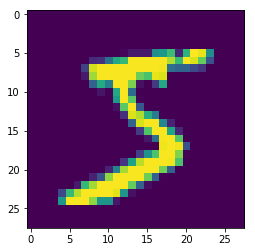

In [10]:
plt.imshow(X_train[0])

In [57]:
from cleverhans.utils import set_log_level
import logging

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

---
# V1

In [59]:
from hinge_net import HingeNet

hingenet = HingeNet("hingenet_v1", [28, 28, 1], [10], learning_rate=1e-3, 
                    loss="hinge", margin=1, load_model=True, 
                    save_path="model/hingenet_v1.h5")
# hingenet.train_model(sess, data, n_epoch=20, batch_size=128)

In [60]:
hingenet.eval_model(sess, (X_test[:, :, :, np.newaxis], np.argmax(y_test, axis=1)))

(0.9906, 0.024141100704669953)

In [61]:
# Least likeley class
n_attack = 1000
X_atk = X_test[:, :, :, np.newaxis][:n_attack]
y_atk = np.argmax(y_test[:n_attack], axis=1)

y_pred = hingenet.predict_model(sess, X_atk)
y_target = to_categorical(np.argmin(y_pred, axis=1))

In [62]:
hingenet.eval_model(sess, (X_atk, y_atk))

(0.989, 0.023215327084064482)

In [ ]:
# Softmax xent

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

from lib.my_pgd import ProjectedGradientDescent

pgd_params = {'eps': 0.3,
              'eps_iter': 0.05,
              'clip_min': 0.,
              'clip_max': 1.,
              'ord': np.inf, 
              'nb_iter': 10,
              'rand_init': True,
              'batch_size': n_attack,
              'y_target': y_target}
pgd = ProjectedGradientDescent(hingenet, sess=sess)

y_tar = np.argmax(y_target, axis=1)
best_adv = np.zeros_like(X_atk)
best_dist = np.zeros([n_attack]) + 1e5
for i in range(10):
    adv = pgd.generate_np(X_atk, **pgd_params)
    print(hingenet.eval_model(sess, (adv, y_tar)))
    dist = np.sqrt(np.sum((adv - X_atk)**2, (1, 2, 3)))
    print(np.mean(dist))
    pred = hingenet.predict_model(sess, adv)
    y_pred = np.argmax(pred, axis=1)
    for j in range(n_attack):
        if y_pred[j] == y_tar[j] and dist[j] < best_dist[j]:
            best_adv[j] = adv[j]
            best_dist[j] = dist[j]
print(np.mean(best_dist < 1e5))
print(np.mean(best_dist[best_dist < 1e5]))

In [ ]:
# Hinge

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

from lib.my_pgd import ProjectedGradientDescent

pgd_params = {'eps': 0.3,
              'eps_iter': 0.05,
              'clip_min': 0.,
              'clip_max': 1.,
              'ord': np.inf, 
              'nb_iter': 10,
              'rand_init': True,
              'batch_size': n_attack,
              'y_target': y_target}
pgd = ProjectedGradientDescent(hingenet, sess=sess)

y_tar = np.argmax(y_target, axis=1)
best_adv = np.zeros_like(X_atk)
best_dist = np.zeros([n_attack]) + 1e5
for i in range(10):
    adv = pgd.generate_np(X_atk, **pgd_params)
    print(hingenet.eval_model(sess, (adv, y_tar)))
    dist = np.sqrt(np.sum((adv - X_atk)**2, (1, 2, 3)))
    print(np.mean(dist))
    pred = hingenet.predict_model(sess, adv)
    y_pred = np.argmax(pred, axis=1)
    for j in range(n_attack):
        if y_pred[j] == y_tar[j] and dist[j] < best_dist[j]:
            best_adv[j] = adv[j]
            best_dist[j] = dist[j]
print(np.mean(best_dist < 1e5))
print(np.mean(best_dist[best_dist < 1e5]))

In [63]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 1000
cw_params = {'binary_search_steps': 10,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': n_attack,
             'initial_const': 1,
             'y_target': y_target}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

[INFO 2018-10-25 03:44:42,421 cleverhans] Constructing new graph for attack CarliniWagnerL2
[DEBUG 2018-10-25 03:44:42,843 cleverhans] Running CWL2 attack on instance 0 of 1000
[DEBUG 2018-10-25 03:44:42,975 cleverhans]   Binary search step 0 of 10
[DEBUG 2018-10-25 03:44:43,210 cleverhans]     Iteration 0 of 1000: loss=16.6 l2=0
[DEBUG 2018-10-25 03:44:46,814 cleverhans]     Iteration 100 of 1000: loss=7.64 l2=5.01
[DEBUG 2018-10-25 03:44:50,281 cleverhans]     Iteration 200 of 1000: loss=7.19 l2=4.98
[DEBUG 2018-10-25 03:44:53,685 cleverhans]     Iteration 300 of 1000: loss=6.18 l2=4.68
[DEBUG 2018-10-25 03:44:57,083 cleverhans]     Iteration 400 of 1000: loss=5.45 l2=4.36
[DEBUG 2018-10-25 03:45:00,423 cleverhans]     Iteration 500 of 1000: loss=4.98 l2=4.15
[DEBUG 2018-10-25 03:45:03,698 cleverhans]     Iteration 600 of 1000: loss=4.68 l2=4.01
[DEBUG 2018-10-25 03:45:06,946 cleverhans]     Iteration 700 of 1000: loss=4.46 l2=3.89
[DEBUG 2018-10-25 03:45:10,110 cleverhans]     Itera

[DEBUG 2018-10-25 03:48:28,332 cleverhans]     Iteration 0 of 1000: loss=17.7 l2=0
[DEBUG 2018-10-25 03:48:31,713 cleverhans]     Iteration 100 of 1000: loss=7.82 l2=4.56
[DEBUG 2018-10-25 03:48:35,046 cleverhans]     Iteration 200 of 1000: loss=7.27 l2=4.5
[DEBUG 2018-10-25 03:48:38,330 cleverhans]     Iteration 300 of 1000: loss=6.36 l2=4.28
[DEBUG 2018-10-25 03:48:41,617 cleverhans]     Iteration 400 of 1000: loss=5.67 l2=4.11
[DEBUG 2018-10-25 03:48:44,916 cleverhans]     Iteration 500 of 1000: loss=5.18 l2=4.04
[DEBUG 2018-10-25 03:48:48,248 cleverhans]     Iteration 600 of 1000: loss=4.83 l2=3.98
[DEBUG 2018-10-25 03:48:51,609 cleverhans]     Iteration 700 of 1000: loss=4.58 l2=3.95
[DEBUG 2018-10-25 03:48:54,932 cleverhans]     Iteration 800 of 1000: loss=4.42 l2=3.91
[DEBUG 2018-10-25 03:48:58,292 cleverhans]     Iteration 900 of 1000: loss=4.29 l2=3.9
[DEBUG 2018-10-25 03:49:01,658 cleverhans]   Successfully generated adversarial examples on 1000 of 1000 instances.
[DEBUG 2018

0.91379666


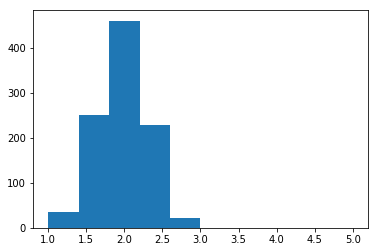

In [64]:
dist = np.sqrt(np.sum((X_atk - adv)**2, (1, 2, 3)))
plt.hist(dist, bins=10, range=(1, 5))
print(np.min(dist))

In [65]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 500
cw_params = {'binary_search_steps': 10,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': n_attack,
             'initial_const': 1}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

[INFO 2018-10-25 03:54:25,789 cleverhans] Constructing new graph for attack CarliniWagnerL2
[DEBUG 2018-10-25 03:54:26,251 cleverhans] Running CWL2 attack on instance 0 of 1000
[DEBUG 2018-10-25 03:54:26,379 cleverhans]   Binary search step 0 of 10
[DEBUG 2018-10-25 03:54:26,626 cleverhans]     Iteration 0 of 500: loss=7.67 l2=0
[DEBUG 2018-10-25 03:54:28,390 cleverhans]     Iteration 50 of 500: loss=3.88 l2=2.47
[DEBUG 2018-10-25 03:54:30,008 cleverhans]     Iteration 100 of 500: loss=3.77 l2=2.41
[DEBUG 2018-10-25 03:54:31,554 cleverhans]     Iteration 150 of 500: loss=3.75 l2=2.41
[DEBUG 2018-10-25 03:54:33,097 cleverhans]     Iteration 200 of 500: loss=3.66 l2=2.39
[DEBUG 2018-10-25 03:54:34,639 cleverhans]     Iteration 250 of 500: loss=3.47 l2=2.34
[DEBUG 2018-10-25 03:54:36,162 cleverhans]     Iteration 300 of 500: loss=3.19 l2=2.31
[DEBUG 2018-10-25 03:54:37,642 cleverhans]     Iteration 350 of 500: loss=2.94 l2=2.26
[DEBUG 2018-10-25 03:54:39,107 cleverhans]     Iteration 400 

[DEBUG 2018-10-25 03:56:24,264 cleverhans]     Iteration 50 of 500: loss=3.73 l2=1.6
[DEBUG 2018-10-25 03:56:25,996 cleverhans]     Iteration 100 of 500: loss=3.67 l2=1.61
[DEBUG 2018-10-25 03:56:27,712 cleverhans]     Iteration 150 of 500: loss=3.66 l2=1.61
[DEBUG 2018-10-25 03:56:29,442 cleverhans]     Iteration 200 of 500: loss=3.63 l2=1.62
[DEBUG 2018-10-25 03:56:31,168 cleverhans]     Iteration 250 of 500: loss=3.54 l2=1.63
[DEBUG 2018-10-25 03:56:32,943 cleverhans]     Iteration 300 of 500: loss=3.4 l2=1.69
[DEBUG 2018-10-25 03:56:34,706 cleverhans]     Iteration 350 of 500: loss=3.21 l2=1.78
[DEBUG 2018-10-25 03:56:36,417 cleverhans]     Iteration 400 of 500: loss=3 l2=1.88
[DEBUG 2018-10-25 03:56:38,087 cleverhans]     Iteration 450 of 500: loss=2.79 l2=1.99
[DEBUG 2018-10-25 03:56:39,755 cleverhans]   Successfully generated adversarial examples on 1000 of 1000 instances.
[DEBUG 2018-10-25 03:56:39,756 cleverhans]    Mean successful distortion: 1.399
[DEBUG 2018-10-25 03:56:39,

In [ ]:
dist = np.sqrt(np.sum((X_atk - adv)**2, (1, 2, 3)))
plt.hist(dist, bins=10, range=(1, 5))
print(np.min(dist))

In [ ]:
y_pred = hingenet.predict_model(sess, adv)

for x, y in zip(adv[:10], y_pred[:10]):
    print(np.argmax(y))
    print(y)
    plt.imshow(x[:, :, 0])
    plt.show()

---
# V2

In [79]:
from hinge_net import HingeNet

# v2: margin = 1e2
hingenet = HingeNet("hingenet_v2", [28, 28, 1], [10], learning_rate=1e-3, 
                    loss="hinge", margin=1e2, load_model=True, 
                    save_path="model/hingenet_v2.h5")
# hingenet.train_model(sess, data, n_epoch=10, batch_size=128)

In [80]:
hingenet.eval_model(sess, (X_test[:, :, :, np.newaxis], np.argmax(y_test, axis=1)))

(0.9884, 2.990084765625)

In [81]:
# Least likeley class
n_attack = 1000
X_atk = X_test[:, :, :, np.newaxis][:n_attack]
y_atk = np.argmax(y_test[:n_attack], axis=1)

y_pred = hingenet.predict_model(sess, X_atk)
y_target = to_categorical(np.argmin(y_pred, axis=1))

In [82]:
hingenet.eval_model(sess, (X_atk, y_atk))

(0.984, 2.9711747179031374)

In [ ]:
# hinge

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

from lib.my_pgd import ProjectedGradientDescent

pgd_params = {'eps': 0.3,
              'eps_iter': 0.05,
              'clip_min': 0.,
              'clip_max': 1.,
              'ord': np.inf, 
              'nb_iter': 10,
              'rand_init': True,
              'batch_size': 100,
              'y_target': y_target}
pgd = ProjectedGradientDescent(hingenet, sess=sess)

y_tar = np.argmax(y_target, axis=1)
best_adv = np.zeros_like(X_atk)
best_dist = np.zeros([n_attack]) + 1e5
for i in range(10):
    adv = pgd.generate_np(X_atk, **pgd_params)
    print(hingenet.eval_model(sess, (adv, y_tar)))
    dist = np.sqrt(np.sum((adv - X_atk)**2, (1, 2, 3)))
    print(np.mean(dist))
    pred = hingenet.predict_model(sess, adv)
    y_pred = np.argmax(pred, axis=1)
    for j in range(n_attack):
        if y_pred[j] == y_tar[j] and dist[j] < best_dist[j]:
            best_adv[j] = adv[j]
            best_dist[j] = dist[j]
print(np.mean(best_dist < 1e5))
print(np.mean(best_dist[best_dist < 1e5]))

In [84]:
# hinge (L2)

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

from lib.my_pgd import ProjectedGradientDescent

pgd_params = {'eps': 3,
              'eps_iter': 0.1,
              'clip_min': 0.,
              'clip_max': 1.,
              'ord': 2, 
              'nb_iter': 50,
              'rand_init': True,
              'batch_size': 100,
              'y_target': y_target}
pgd = ProjectedGradientDescent(hingenet, sess=sess)

y_tar = np.argmax(y_target, axis=1)
best_adv = np.zeros_like(X_atk)
best_dist = np.zeros([n_attack]) + 1e5
for i in range(10):
    adv = pgd.generate_np(X_atk, **pgd_params)
    print(hingenet.eval_model(sess, (adv, y_tar)))
    dist = np.sqrt(np.sum((adv - X_atk)**2, (1, 2, 3)))
    print(np.mean(dist))
    pred = hingenet.predict_model(sess, adv)
    y_pred = np.argmax(pred, axis=1)
    for j in range(n_attack):
        if y_pred[j] == y_tar[j] and dist[j] < best_dist[j]:
            best_adv[j] = adv[j]
            best_dist[j] = dist[j]
print(np.mean(best_dist < 1e5))
print(np.mean(best_dist[best_dist < 1e5]))

/home/research/nn_proof/lib/my_pgd.py:698: UserWarning: Supplied extra keyword arguments that are not used in the graph computation. They have been ignored.
  warnings.warn("Supplied extra keyword arguments that are not "
[INFO 2018-10-25 04:22:05,456 cleverhans] Constructing new graph for attack ProjectedGradientDescent


(0.554, 183.33179663085937)
2.9768095
(0.554, 183.37975463867187)
2.9768062
(0.548, 183.37214916992187)
2.9768112
(0.56, 183.84378784179688)
2.9762034
(0.564, 182.48850793457032)
2.975016
(0.554, 183.09268420410157)
2.9752016
(0.563, 182.54222802734375)
2.975842
(0.562, 183.00726904296874)
2.9749937
(0.556, 182.86801904296874)
2.9760473
(0.558, 182.0998671875)
2.9771123
0.63
2.9424975815273466


In [ ]:
# hinge (untargeted)

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

from lib.my_pgd import ProjectedGradientDescent

pgd_params = {'eps': 0.3,
              'eps_iter': 0.05,
              'clip_min': 0.,
              'clip_max': 1.,
              'ord': np.inf, 
              'nb_iter': 10,
              'rand_init': True,
              'batch_size': 100}
pgd = ProjectedGradientDescent(hingenet, sess=sess)

y_tar = np.argmax(y_target, axis=1)
best_adv = np.zeros_like(X_atk)
best_dist = np.zeros([n_attack]) + 1e5
for i in range(10):
    adv = pgd.generate_np(X_atk, **pgd_params)
    print(hingenet.eval_model(sess, (adv, y_tar)))
    dist = np.sqrt(np.sum((adv - X_atk)**2, (1, 2, 3)))
    print(np.mean(dist))
    pred = hingenet.predict_model(sess, adv)
    y_pred = np.argmax(pred, axis=1)
    for j in range(n_attack):
        if y_pred[j] == y_tar[j] and dist[j] < best_dist[j]:
            best_adv[j] = adv[j]
            best_dist[j] = dist[j]
print(np.mean(best_dist < 1e5))
print(np.mean(best_dist[best_dist < 1e5]))

In [32]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 500
cw_params = {'binary_search_steps': 10,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': n_attack,
             'initial_const': 1,
             'y_target': y_target}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

[INFO 2018-10-25 00:46:47,241 cleverhans] Constructing new graph for attack CarliniWagnerL2
[DEBUG 2018-10-25 00:46:47,648 cleverhans] Running CWL2 attack on instance 0 of 1000
[DEBUG 2018-10-25 00:46:47,759 cleverhans]   Binary search step 0 of 10
[DEBUG 2018-10-25 00:46:47,946 cleverhans]     Iteration 0 of 500: loss=1.33e+03 l2=0
[DEBUG 2018-10-25 00:46:49,447 cleverhans]     Iteration 50 of 500: loss=86.8 l2=41.6
[DEBUG 2018-10-25 00:46:50,574 cleverhans]     Iteration 100 of 500: loss=35.7 l2=35.7
[DEBUG 2018-10-25 00:46:52,084 cleverhans]     Iteration 150 of 500: loss=29.9 l2=29.8
[DEBUG 2018-10-25 00:46:53,585 cleverhans]     Iteration 200 of 500: loss=26.7 l2=26.7
[DEBUG 2018-10-25 00:46:54,958 cleverhans]     Iteration 250 of 500: loss=24.6 l2=24.6
[DEBUG 2018-10-25 00:46:56,213 cleverhans]     Iteration 300 of 500: loss=23.1 l2=23.1
[DEBUG 2018-10-25 00:46:57,415 cleverhans]     Iteration 350 of 500: loss=21.8 l2=21.7
[DEBUG 2018-10-25 00:46:58,605 cleverhans]     Iteration 

[DEBUG 2018-10-25 00:48:18,194 cleverhans]     Iteration 50 of 500: loss=13.1 l2=5.94
[DEBUG 2018-10-25 00:48:19,832 cleverhans]     Iteration 100 of 500: loss=13 l2=5.92
[DEBUG 2018-10-25 00:48:21,478 cleverhans]     Iteration 150 of 500: loss=12.8 l2=5.96
[DEBUG 2018-10-25 00:48:23,128 cleverhans]     Iteration 200 of 500: loss=12.1 l2=6.08
[DEBUG 2018-10-25 00:48:24,774 cleverhans]     Iteration 250 of 500: loss=11.2 l2=6.09
[DEBUG 2018-10-25 00:48:26,417 cleverhans]     Iteration 300 of 500: loss=10.5 l2=6.04
[DEBUG 2018-10-25 00:48:28,020 cleverhans]     Iteration 350 of 500: loss=9.88 l2=6.04
[DEBUG 2018-10-25 00:48:29,608 cleverhans]     Iteration 400 of 500: loss=9.42 l2=6.04
[DEBUG 2018-10-25 00:48:31,218 cleverhans]     Iteration 450 of 500: loss=9.05 l2=6.04
[DEBUG 2018-10-25 00:48:32,865 cleverhans]   Successfully generated adversarial examples on 1000 of 1000 instances.
[DEBUG 2018-10-25 00:48:32,866 cleverhans]    Mean successful distortion: 2.914
[DEBUG 2018-10-25 00:48:

1.2748419


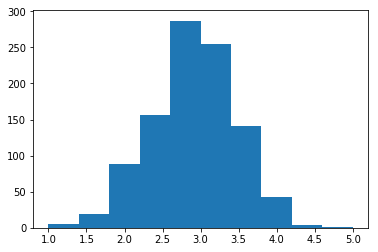

In [34]:
dist = np.sqrt(np.sum((X_atk - adv)**2, (1, 2, 3)))
plt.hist(dist, bins=10, range=(1, 5))
print(np.min(dist))

In [35]:
# Untargeted

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 500
cw_params = {'binary_search_steps': 10,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': n_attack,
             'initial_const': 1}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

[INFO 2018-10-25 00:51:07,269 cleverhans] Constructing new graph for attack CarliniWagnerL2
[DEBUG 2018-10-25 00:51:07,626 cleverhans] Running CWL2 attack on instance 0 of 1000
[DEBUG 2018-10-25 00:51:07,742 cleverhans]   Binary search step 0 of 10
[DEBUG 2018-10-25 00:51:07,934 cleverhans]     Iteration 0 of 500: loss=503 l2=0
[DEBUG 2018-10-25 00:51:09,129 cleverhans]     Iteration 50 of 500: loss=24.8 l2=17.9
[DEBUG 2018-10-25 00:51:10,143 cleverhans]     Iteration 100 of 500: loss=12.1 l2=12
[DEBUG 2018-10-25 00:51:11,574 cleverhans]     Iteration 150 of 500: loss=9.66 l2=9.62
[DEBUG 2018-10-25 00:51:12,890 cleverhans]     Iteration 200 of 500: loss=8.79 l2=8.76
[DEBUG 2018-10-25 00:51:14,079 cleverhans]     Iteration 250 of 500: loss=8.19 l2=8.15
[DEBUG 2018-10-25 00:51:15,210 cleverhans]     Iteration 300 of 500: loss=7.76 l2=7.73
[DEBUG 2018-10-25 00:51:16,280 cleverhans]     Iteration 350 of 500: loss=7.41 l2=7.35
[DEBUG 2018-10-25 00:51:17,349 cleverhans]     Iteration 400 of 

[DEBUG 2018-10-25 00:52:29,333 cleverhans]     Iteration 50 of 500: loss=3.48 l2=1.3
[DEBUG 2018-10-25 00:52:30,965 cleverhans]     Iteration 100 of 500: loss=3.47 l2=1.3
[DEBUG 2018-10-25 00:52:32,575 cleverhans]     Iteration 150 of 500: loss=3.46 l2=1.3
[DEBUG 2018-10-25 00:52:34,183 cleverhans]     Iteration 200 of 500: loss=3.44 l2=1.32
[DEBUG 2018-10-25 00:52:35,805 cleverhans]     Iteration 250 of 500: loss=3.33 l2=1.36
[DEBUG 2018-10-25 00:52:37,405 cleverhans]     Iteration 300 of 500: loss=3.17 l2=1.43
[DEBUG 2018-10-25 00:52:38,968 cleverhans]     Iteration 350 of 500: loss=3.01 l2=1.46
[DEBUG 2018-10-25 00:52:40,515 cleverhans]     Iteration 400 of 500: loss=2.87 l2=1.5
[DEBUG 2018-10-25 00:52:42,091 cleverhans]     Iteration 450 of 500: loss=2.74 l2=1.55
[DEBUG 2018-10-25 00:52:43,699 cleverhans]   Successfully generated adversarial examples on 1000 of 1000 instances.
[DEBUG 2018-10-25 00:52:43,700 cleverhans]    Mean successful distortion: 1.477
[DEBUG 2018-10-25 00:52:43

0.052413613


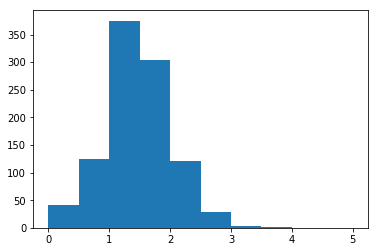

In [37]:
dist = np.sqrt(np.sum((X_atk - adv)**2, (1, 2, 3)))
plt.hist(dist, bins=10, range=(0, 5))
print(np.min(dist))

In [ ]:
output = hingenet.predict_model(sess, adv)
y_pred = np.argmax(output, axis=1)
max_out = np.max(output, axis=1)
ind = []
y_target = np.argmax(y_target, axis=1)
for i in range(n_attack):
    if y_pred[i] == y_target[i]:
        ind.append(i)
ind = np.array(ind)
avg_out = np.mean(max_out[ind])
dist = np.mean(np.sqrt(np.sum((adv[ind] - X_atk[ind])**2, (1, 2, 3))))
print(avg_out)
print(dist)

In [ ]:
y_pred = hingenet.predict_model(sess, adv)

for x, y in zip(adv[:10], y_pred[:10]):
    print(np.argmax(y))
    print(y)
    plt.imshow(x[:, :, 0])
    plt.show()

# V2.1

In [249]:
from hinge_net import HingeNet

# v2: margin = 1e2
hingenet = HingeNet("hingenet_v2.3", [28, 28, 1], [10], learning_rate=1e-3, 
                    loss="hinge", margin=1e2, load_model=False, reg=1e-1,
                    save_path="model/hingenet_v2.3.h5")
hingenet.train_model(sess, data, n_epoch=20, batch_size=128)

============= EPOCH: 0 =============
STEP: 0 	Loss: 209.0180
STEP: 50 	Loss: 101.9859
STEP: 100 	Loss: 100.0184
STEP: 150 	Loss: 100.0015
STEP: 200 	Loss: 100.0007
STEP: 250 	Loss: 100.0004
STEP: 300 	Loss: 100.0008
STEP: 350 	Loss: 100.0004
STEP: 400 	Loss: 100.0005
STEP: 450 	Loss: 100.0006
Train Acc|Loss:	0.0992|100.0007
Val Acc|Loss:	0.1009|100.0007
============= EPOCH: 1 =============
STEP: 0 	Loss: 100.0007
STEP: 50 	Loss: 100.0005
STEP: 100 	Loss: 100.0005
STEP: 150 	Loss: 100.0007
STEP: 200 	Loss: 100.0006
STEP: 250 	Loss: 100.0004
STEP: 300 	Loss: 100.0004
STEP: 350 	Loss: 100.0004
STEP: 400 	Loss: 100.0003
STEP: 450 	Loss: 100.0006


Exception ignored in: <bound method TF_Output.<lambda> of <tensorflow.python.pywrap_tensorflow_internal.TF_Output; proxy of <Swig Object of type 'TF_Output *' at 0x7fa4622c0f90> >>
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 963, in <lambda>
    __del__ = lambda self: None
KeyboardInterrupt


Train Acc|Loss:	0.1124|100.0005
Val Acc|Loss:	0.1135|100.0005
============= EPOCH: 2 =============
STEP: 0 	Loss: 100.0005
STEP: 50 	Loss: 100.0006
STEP: 100 	Loss: 100.0003
STEP: 150 	Loss: 100.0003
STEP: 200 	Loss: 100.0004
STEP: 250 	Loss: 100.0005
STEP: 300 	Loss: 100.0008
STEP: 350 	Loss: 100.0005
STEP: 400 	Loss: 100.0004
STEP: 450 	Loss: 100.0004
Train Acc|Loss:	0.0975|100.0006
Val Acc|Loss:	0.0974|100.0006
============= EPOCH: 3 =============
STEP: 0 	Loss: 100.0006
STEP: 50 	Loss: 100.0006
STEP: 100 	Loss: 100.0007
STEP: 150 	Loss: 100.0005
STEP: 200 	Loss: 100.0005
STEP: 250 	Loss: 100.0007
STEP: 300 	Loss: 100.0002
STEP: 350 	Loss: 100.0005
STEP: 400 	Loss: 100.0005
STEP: 450 	Loss: 100.0008


KeyboardInterrupt: 

In [244]:
hingenet.eval_model(sess, (X_test[:, :, :, np.newaxis], np.argmax(y_test, axis=1)))

(0.9911, 6.859127086639404)

In [245]:
# Least likeley class
n_attack = 1000
X_atk = X_test[:, :, :, np.newaxis][:n_attack]
y_atk = np.argmax(y_test[:n_attack], axis=1)

y_pred = hingenet.predict_model(sess, X_atk)
y_target = to_categorical(np.argmin(y_pred, axis=1))

In [246]:
hingenet.eval_model(sess, (X_atk, y_atk))

(0.989, 7.350222396850586)

In [247]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 500
cw_params = {'binary_search_steps': 10,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': n_attack,
             'initial_const': 1,
             'y_target': y_target}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

[INFO 2018-10-25 18:21:55,441 cleverhans] Constructing new graph for attack CarliniWagnerL2
[DEBUG 2018-10-25 18:21:56,912 cleverhans] Running CWL2 attack on instance 0 of 1000
[DEBUG 2018-10-25 18:21:57,314 cleverhans]   Binary search step 0 of 10
[DEBUG 2018-10-25 18:21:58,066 cleverhans]     Iteration 0 of 500: loss=620 l2=0
[DEBUG 2018-10-25 18:21:59,179 cleverhans]     Iteration 50 of 500: loss=60.8 l2=36.1
[DEBUG 2018-10-25 18:22:00,212 cleverhans]     Iteration 100 of 500: loss=29.3 l2=28.8
[DEBUG 2018-10-25 18:22:01,341 cleverhans]     Iteration 150 of 500: loss=24.6 l2=24.6
[DEBUG 2018-10-25 18:22:02,259 cleverhans]     Iteration 200 of 500: loss=22.1 l2=22
[DEBUG 2018-10-25 18:22:03,087 cleverhans]     Iteration 250 of 500: loss=20.1 l2=20
[DEBUG 2018-10-25 18:22:03,850 cleverhans]     Iteration 300 of 500: loss=18.6 l2=18.5
[DEBUG 2018-10-25 18:22:04,562 cleverhans]     Iteration 350 of 500: loss=17.5 l2=17.4
[DEBUG 2018-10-25 18:22:05,227 cleverhans]     Iteration 400 of 50

[DEBUG 2018-10-25 18:23:05,016 cleverhans]     Iteration 50 of 500: loss=14.7 l2=6.85
[DEBUG 2018-10-25 18:23:06,338 cleverhans]     Iteration 100 of 500: loss=14.6 l2=6.85
[DEBUG 2018-10-25 18:23:07,646 cleverhans]     Iteration 150 of 500: loss=14.5 l2=6.88
[DEBUG 2018-10-25 18:23:08,955 cleverhans]     Iteration 200 of 500: loss=14.1 l2=7.01
[DEBUG 2018-10-25 18:23:10,249 cleverhans]     Iteration 250 of 500: loss=13.3 l2=7.4
[DEBUG 2018-10-25 18:23:11,538 cleverhans]     Iteration 300 of 500: loss=12.4 l2=7.81
[DEBUG 2018-10-25 18:23:12,795 cleverhans]     Iteration 350 of 500: loss=11.6 l2=8.11
[DEBUG 2018-10-25 18:23:14,058 cleverhans]     Iteration 400 of 500: loss=11 l2=8.35
[DEBUG 2018-10-25 18:23:15,312 cleverhans]     Iteration 450 of 500: loss=10.6 l2=8.5
[DEBUG 2018-10-25 18:23:16,583 cleverhans]   Successfully generated adversarial examples on 1000 of 1000 instances.
[DEBUG 2018-10-25 18:23:16,584 cleverhans]    Mean successful distortion: 3.067
[DEBUG 2018-10-25 18:23:16

---
# V3

In [66]:
from hinge_net import HingeNet

# v3: margin = 1e3
hingenet = HingeNet("hingenet_v3", [28, 28, 1], [10], learning_rate=1e-3, 
                    loss="hinge", margin=1e3, load_model=True, 
                    save_path="model/hingenet_v3.h5")
# hingenet.train_model(sess, data, n_epoch=20, batch_size=128)

In [67]:
hingenet.eval_model(sess, (X_test[:, :, :, np.newaxis], np.argmax(y_test, axis=1)))

(0.9883, 29.553343701171876)

In [68]:
# Least likeley class
n_attack = 1000
X_atk = X_test[:, :, :, np.newaxis][:n_attack]
y_atk = np.argmax(y_test[:n_attack], axis=1)

y_pred = hingenet.predict_model(sess, X_atk)
y_target = to_categorical(np.argmin(y_pred, axis=1))

In [69]:
hingenet.eval_model(sess, (X_atk, y_atk))

(0.986, 33.34422201538086)

In [70]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 1000
cw_params = {'binary_search_steps': 10,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': n_attack,
             'initial_const': 1,
             'y_target': y_target}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

[INFO 2018-10-25 03:59:54,236 cleverhans] Constructing new graph for attack CarliniWagnerL2
[DEBUG 2018-10-25 03:59:54,651 cleverhans] Running CWL2 attack on instance 0 of 1000
[DEBUG 2018-10-25 03:59:54,807 cleverhans]   Binary search step 0 of 10
[DEBUG 2018-10-25 03:59:55,060 cleverhans]     Iteration 0 of 1000: loss=1.1e+04 l2=0
[DEBUG 2018-10-25 03:59:57,457 cleverhans]     Iteration 100 of 1000: loss=47.8 l2=47.8
[DEBUG 2018-10-25 03:59:59,345 cleverhans]     Iteration 200 of 1000: loss=42.8 l2=42.8
[DEBUG 2018-10-25 04:00:01,328 cleverhans]     Iteration 300 of 1000: loss=38.6 l2=38.6
[DEBUG 2018-10-25 04:00:03,656 cleverhans]     Iteration 400 of 1000: loss=35.1 l2=35.1
[DEBUG 2018-10-25 04:00:06,409 cleverhans]     Iteration 500 of 1000: loss=32.6 l2=32.6
[DEBUG 2018-10-25 04:00:09,404 cleverhans]     Iteration 600 of 1000: loss=31.4 l2=31.4
[DEBUG 2018-10-25 04:00:12,246 cleverhans]     Iteration 700 of 1000: loss=30.4 l2=30.4
[DEBUG 2018-10-25 04:00:14,936 cleverhans]     It

[DEBUG 2018-10-25 04:02:29,597 cleverhans]     Iteration 0 of 1000: loss=85.9 l2=0
[DEBUG 2018-10-25 04:02:32,298 cleverhans]     Iteration 100 of 1000: loss=19.9 l2=16.6
[DEBUG 2018-10-25 04:02:34,696 cleverhans]     Iteration 200 of 1000: loss=15 l2=14.7
[DEBUG 2018-10-25 04:02:37,005 cleverhans]     Iteration 300 of 1000: loss=12.1 l2=11.9
[DEBUG 2018-10-25 04:02:39,158 cleverhans]     Iteration 400 of 1000: loss=10.6 l2=10.4
[DEBUG 2018-10-25 04:02:41,270 cleverhans]     Iteration 500 of 1000: loss=9.84 l2=9.63
[DEBUG 2018-10-25 04:02:43,347 cleverhans]     Iteration 600 of 1000: loss=9.3 l2=9.06
[DEBUG 2018-10-25 04:02:45,421 cleverhans]     Iteration 700 of 1000: loss=8.88 l2=8.66
[DEBUG 2018-10-25 04:02:47,540 cleverhans]     Iteration 800 of 1000: loss=8.63 l2=8.44
[DEBUG 2018-10-25 04:02:49,682 cleverhans]     Iteration 900 of 1000: loss=8.44 l2=8.26
[DEBUG 2018-10-25 04:02:51,822 cleverhans]   Successfully generated adversarial examples on 1000 of 1000 instances.
[DEBUG 2018-

1.1131817


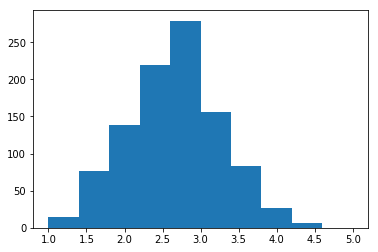

In [71]:
dist = np.sqrt(np.sum((X_atk - adv)**2, (1, 2, 3)))
plt.hist(dist, bins=10, range=(1, 5))
print(np.min(dist))

In [72]:
# Untargeted

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 500
cw_params = {'binary_search_steps': 10,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': n_attack,
             'initial_const': 1}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

[INFO 2018-10-25 04:04:07,861 cleverhans] Constructing new graph for attack CarliniWagnerL2
[DEBUG 2018-10-25 04:04:08,525 cleverhans] Running CWL2 attack on instance 0 of 1000
[DEBUG 2018-10-25 04:04:08,663 cleverhans]   Binary search step 0 of 10
[DEBUG 2018-10-25 04:04:08,942 cleverhans]     Iteration 0 of 500: loss=4.11e+03 l2=0
[DEBUG 2018-10-25 04:04:10,104 cleverhans]     Iteration 50 of 500: loss=67.1 l2=24.6
[DEBUG 2018-10-25 04:04:11,029 cleverhans]     Iteration 100 of 500: loss=22.4 l2=22.4
[DEBUG 2018-10-25 04:04:11,916 cleverhans]     Iteration 150 of 500: loss=19.6 l2=19.6
[DEBUG 2018-10-25 04:04:12,810 cleverhans]     Iteration 200 of 500: loss=17.4 l2=17.4
[DEBUG 2018-10-25 04:04:13,704 cleverhans]     Iteration 250 of 500: loss=15.7 l2=15.7
[DEBUG 2018-10-25 04:04:14,664 cleverhans]     Iteration 300 of 500: loss=14.2 l2=14.2
[DEBUG 2018-10-25 04:04:15,665 cleverhans]     Iteration 350 of 500: loss=13 l2=13
[DEBUG 2018-10-25 04:04:16,804 cleverhans]     Iteration 400 

[DEBUG 2018-10-25 04:05:26,243 cleverhans]     Iteration 50 of 500: loss=6.16 l2=5.52
[DEBUG 2018-10-25 04:05:27,397 cleverhans]     Iteration 100 of 500: loss=5.57 l2=4.98
[DEBUG 2018-10-25 04:05:28,490 cleverhans]     Iteration 150 of 500: loss=4.98 l2=4.82
[DEBUG 2018-10-25 04:05:29,578 cleverhans]     Iteration 200 of 500: loss=4.45 l2=4.35
[DEBUG 2018-10-25 04:05:30,651 cleverhans]     Iteration 250 of 500: loss=4 l2=3.92
[DEBUG 2018-10-25 04:05:31,707 cleverhans]     Iteration 300 of 500: loss=3.66 l2=3.56
[DEBUG 2018-10-25 04:05:32,762 cleverhans]     Iteration 350 of 500: loss=3.35 l2=3.27
[DEBUG 2018-10-25 04:05:33,817 cleverhans]     Iteration 400 of 500: loss=3.16 l2=3.06
[DEBUG 2018-10-25 04:05:34,882 cleverhans]     Iteration 450 of 500: loss=2.96 l2=2.88
[DEBUG 2018-10-25 04:05:35,973 cleverhans]   Successfully generated adversarial examples on 1000 of 1000 instances.
[DEBUG 2018-10-25 04:05:35,974 cleverhans]    Mean successful distortion: 1.51
[DEBUG 2018-10-25 04:05:35

In [ ]:
y_pred = hingenet.predict_model(sess, adv)

for x, y in zip(adv[:10], y_pred[:10]):
    print(np.argmax(y))
    print(y)
    plt.imshow(x[:, :, 0])
    plt.show()

In [ ]:
# hinge

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

from lib.my_pgd import ProjectedGradientDescent

pgd_params = {'eps': 0.3,
              'eps_iter': 0.05,
              'clip_min': 0.,
              'clip_max': 1.,
              'ord': np.inf, 
              'nb_iter': 10,
              'rand_init': True,
              'batch_size': 100,
              'y_target': y_target}
pgd = ProjectedGradientDescent(hingenet, sess=sess)

y_tar = np.argmax(y_target, axis=1)
best_adv = np.zeros_like(X_atk)
best_dist = np.zeros([n_attack]) + 1e5
for i in range(10):
    adv = pgd.generate_np(X_atk, **pgd_params)
    print(hingenet.eval_model(sess, (adv, y_tar)))
    dist = np.sqrt(np.sum((adv - X_atk)**2, (1, 2, 3)))
    print(np.mean(dist))
    pred = hingenet.predict_model(sess, adv)
    y_pred = np.argmax(pred, axis=1)
    for j in range(n_attack):
        if y_pred[j] == y_tar[j] and dist[j] < best_dist[j]:
            best_adv[j] = adv[j]
            best_dist[j] = dist[j]
print(np.mean(best_dist < 1e5))
print(np.mean(best_dist[best_dist < 1e5]))

---
# V4

In [ ]:
from hinge_net import HingeNet

# v4: margin = 1e4
hingenet = HingeNet("hingenet_v4", [28, 28, 1], [10], learning_rate=1e-3, 
                    load_model=False, save_path="model/hingenet_v4.h5")
hingenet.train_model(sess, data, n_epoch=20, batch_size=128)

In [ ]:
# Least likeley class
n_attack = 1000
X_atk = X_test[:, :, :, np.newaxis][:n_attack]
y_atk = np.argmax(y_test[:n_attack], axis=1)

y_pred = hingenet.predict_model(sess, X_atk)
y_target = to_categorical(np.argmin(y_pred, axis=1))

In [ ]:
hingenet.eval_model(sess, (X_atk, y_atk))

In [ ]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 200
cw_params = {'binary_search_steps': 3,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': n_attack,
             'initial_const': 10,
             'y_target': y_target}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

In [ ]:
w = hingenet.model.get_weights()

print(np.sum(np.square(w[0])))
print(np.sum(np.square(w[2])))
print(np.sum(np.square(w[4])))
print(np.sum(np.square(w[6])))

In [ ]:
# Untargeted

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 500
cw_params = {'binary_search_steps': 10,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': n_attack,
             'initial_const': 1}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

In [ ]:
plt.imshow(adv[0, :, :, 0])

---
# V5

In [109]:
from hinge_net import HingeNet

# v5: margin = 1e2 + reg
hingenet = HingeNet("hingenet_v5-1", [28, 28, 1], [10], learning_rate=1e-3, 
                    loss="hinge", margin=1e4, reg=1e-1, load_model=False, 
                    save_path="model/hingenet_v5-1.h5")
hingenet.train_model(sess, data, n_epoch=50, batch_size=128)

============= EPOCH: 0 =============
STEP: 0 	Loss: 10031.5703
STEP: 50 	Loss: 10001.4043
STEP: 100 	Loss: 9969.8730
STEP: 150 	Loss: 7612.9800
STEP: 200 	Loss: 4472.9331
STEP: 250 	Loss: 4255.9438
STEP: 300 	Loss: 3731.2759
STEP: 350 	Loss: 2836.6436
STEP: 400 	Loss: 2508.3191
STEP: 450 	Loss: 2331.2664
Train Acc|Loss:	0.9145|2714.2508
Val Acc|Loss:	0.9151|2662.6128
============= EPOCH: 1 =============
STEP: 0 	Loss: 2292.3208
STEP: 50 	Loss: 2896.3645
STEP: 100 	Loss: 2383.5132
STEP: 150 	Loss: 2436.2559
STEP: 200 	Loss: 1670.5460
STEP: 250 	Loss: 1703.5331
STEP: 300 	Loss: 1677.0099
STEP: 350 	Loss: 1989.6921
STEP: 400 	Loss: 2093.4607
STEP: 450 	Loss: 1463.8815
Train Acc|Loss:	0.9415|1990.9160
Val Acc|Loss:	0.9453|1920.4313
============= EPOCH: 2 =============
STEP: 0 	Loss: 2012.2522
STEP: 50 	Loss: 2409.0957
STEP: 100 	Loss: 1434.1931
STEP: 150 	Loss: 2145.7148
STEP: 200 	Loss: 1398.4541
STEP: 250 	Loss: 1898.4948
STEP: 300 	Loss: 1257.0391
STEP: 350 	Loss: 1776.1799
STEP: 400 	L

STEP: 350 	Loss: 657.1849
STEP: 400 	Loss: 725.9612
STEP: 450 	Loss: 1031.5901
Train Acc|Loss:	0.9871|778.5040
Val Acc|Loss:	0.9799|924.9560
============= EPOCH: 23 =============
STEP: 0 	Loss: 804.8555
STEP: 50 	Loss: 803.9576
STEP: 100 	Loss: 1076.4960
STEP: 150 	Loss: 1090.1317
STEP: 200 	Loss: 750.8539
STEP: 250 	Loss: 676.6818
STEP: 300 	Loss: 542.9648
STEP: 350 	Loss: 807.2509
STEP: 400 	Loss: 803.5764
STEP: 450 	Loss: 783.8573
Train Acc|Loss:	0.9862|771.5240
Val Acc|Loss:	0.9807|898.1437
============= EPOCH: 24 =============
STEP: 0 	Loss: 793.9789
STEP: 50 	Loss: 923.0577
STEP: 100 	Loss: 771.3162
STEP: 150 	Loss: 816.7993
STEP: 200 	Loss: 877.8324
STEP: 250 	Loss: 643.0286
STEP: 300 	Loss: 812.8512
STEP: 350 	Loss: 735.9905
STEP: 400 	Loss: 1014.7610
STEP: 450 	Loss: 587.5442
Train Acc|Loss:	0.9864|779.3913
Val Acc|Loss:	0.9804|918.5250
============= EPOCH: 25 =============
STEP: 0 	Loss: 783.9938
STEP: 50 	Loss: 1178.1173
STEP: 100 	Loss: 689.4994
STEP: 150 	Loss: 582.1693
ST

STEP: 300 	Loss: 717.8231
STEP: 350 	Loss: 723.5996
STEP: 400 	Loss: 414.5781
STEP: 450 	Loss: 787.6606
Train Acc|Loss:	0.9933|561.4125
Val Acc|Loss:	0.9860|731.6640
============= EPOCH: 46 =============
STEP: 0 	Loss: 757.5205
STEP: 50 	Loss: 614.4608
STEP: 100 	Loss: 883.1051
STEP: 150 	Loss: 464.9293
STEP: 200 	Loss: 899.2601
STEP: 250 	Loss: 483.2147
STEP: 300 	Loss: 443.1342
STEP: 350 	Loss: 565.9550
STEP: 400 	Loss: 979.5234
STEP: 450 	Loss: 489.1190
Train Acc|Loss:	0.9932|549.2773
Val Acc|Loss:	0.9852|718.9295
============= EPOCH: 47 =============
STEP: 0 	Loss: 596.2688
STEP: 50 	Loss: 440.9027
STEP: 100 	Loss: 489.1025
STEP: 150 	Loss: 479.1650
STEP: 200 	Loss: 734.0414
STEP: 250 	Loss: 672.0727
STEP: 300 	Loss: 440.2168
STEP: 350 	Loss: 750.8029
STEP: 400 	Loss: 457.6168
STEP: 450 	Loss: 537.2766
Train Acc|Loss:	0.9928|578.9889
Val Acc|Loss:	0.9854|730.4372
============= EPOCH: 48 =============
STEP: 0 	Loss: 559.2588
STEP: 50 	Loss: 593.9353
STEP: 100 	Loss: 688.8085
STEP: 1

In [110]:
hingenet.eval_model(sess, (X_test[:, :, :, np.newaxis], np.argmax(y_test, axis=1)))

(0.9855, 715.4266571289063)

In [111]:
w = hingenet.model.get_weights()
for i, w in enumerate(w):
    if i % 2 == 0:
        print(np.sum(np.square(w)))

796.31085
702.4912
1592.8695
246.33667


In [112]:
# Least likeley class
n_attack = 1000
X_atk = X_test[:, :, :, np.newaxis][:n_attack]
y_atk = np.argmax(y_test[:n_attack], axis=1)

y_pred = hingenet.predict_model(sess, X_atk)
y_target = to_categorical(np.argmin(y_pred, axis=1))

In [113]:
hingenet.eval_model(sess, (X_atk, y_atk))

(0.984, 824.484859375)

In [114]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 500
cw_params = {'binary_search_steps': 10,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': n_attack,
             'initial_const': 1,
             'y_target': y_target}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

[INFO 2018-10-25 05:33:40,661 cleverhans] Constructing new graph for attack CarliniWagnerL2
[DEBUG 2018-10-25 05:33:41,298 cleverhans] Running CWL2 attack on instance 0 of 1000
[DEBUG 2018-10-25 05:33:41,497 cleverhans]   Binary search step 0 of 10
[DEBUG 2018-10-25 05:33:41,868 cleverhans]     Iteration 0 of 500: loss=7.92e+04 l2=0
[DEBUG 2018-10-25 05:33:43,360 cleverhans]     Iteration 50 of 500: loss=2.49e+03 l2=43.7
[DEBUG 2018-10-25 05:33:44,288 cleverhans]     Iteration 100 of 500: loss=48.5 l2=48.5
[DEBUG 2018-10-25 05:33:45,191 cleverhans]     Iteration 150 of 500: loss=48 l2=48
[DEBUG 2018-10-25 05:33:46,099 cleverhans]     Iteration 200 of 500: loss=47.6 l2=47.6
[DEBUG 2018-10-25 05:33:47,034 cleverhans]     Iteration 250 of 500: loss=47.1 l2=47.1
[DEBUG 2018-10-25 05:33:47,938 cleverhans]     Iteration 300 of 500: loss=46.6 l2=46.6
[DEBUG 2018-10-25 05:33:48,867 cleverhans]     Iteration 350 of 500: loss=46.1 l2=46.1
[DEBUG 2018-10-25 05:33:49,795 cleverhans]     Iteration 

[DEBUG 2018-10-25 05:35:00,370 cleverhans]     Iteration 50 of 500: loss=58.9 l2=36.2
[DEBUG 2018-10-25 05:35:01,551 cleverhans]     Iteration 100 of 500: loss=29.3 l2=28.8
[DEBUG 2018-10-25 05:35:02,805 cleverhans]     Iteration 150 of 500: loss=25 l2=25
[DEBUG 2018-10-25 05:35:03,959 cleverhans]     Iteration 200 of 500: loss=22.7 l2=22.6
[DEBUG 2018-10-25 05:35:05,051 cleverhans]     Iteration 250 of 500: loss=20.8 l2=20.7
[DEBUG 2018-10-25 05:35:06,128 cleverhans]     Iteration 300 of 500: loss=19.5 l2=19.3
[DEBUG 2018-10-25 05:35:07,194 cleverhans]     Iteration 350 of 500: loss=18.4 l2=18.2
[DEBUG 2018-10-25 05:35:08,268 cleverhans]     Iteration 400 of 500: loss=17.5 l2=17.3
[DEBUG 2018-10-25 05:35:09,319 cleverhans]     Iteration 450 of 500: loss=16.8 l2=16.6
[DEBUG 2018-10-25 05:35:10,365 cleverhans]   Successfully generated adversarial examples on 1000 of 1000 instances.
[DEBUG 2018-10-25 05:35:10,367 cleverhans]    Mean successful distortion: 3.709
[DEBUG 2018-10-25 05:35:10

In [115]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 2000
cw_params = {'binary_search_steps': 10,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': n_attack,
             'initial_const': 1,
             'y_target': y_target}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

[INFO 2018-10-25 05:35:33,062 cleverhans] Constructing new graph for attack CarliniWagnerL2
[DEBUG 2018-10-25 05:35:33,760 cleverhans] Running CWL2 attack on instance 0 of 1000
[DEBUG 2018-10-25 05:35:33,964 cleverhans]   Binary search step 0 of 10
[DEBUG 2018-10-25 05:35:34,330 cleverhans]     Iteration 0 of 2000: loss=7.92e+04 l2=0
[DEBUG 2018-10-25 05:35:38,534 cleverhans]     Iteration 200 of 2000: loss=47.6 l2=47.6
[DEBUG 2018-10-25 05:35:42,151 cleverhans]     Iteration 400 of 2000: loss=45.6 l2=45.6
[DEBUG 2018-10-25 05:35:45,950 cleverhans]     Iteration 600 of 2000: loss=43.4 l2=43.4
[DEBUG 2018-10-25 05:35:49,916 cleverhans]     Iteration 800 of 2000: loss=41.3 l2=41.3
[DEBUG 2018-10-25 05:35:54,212 cleverhans]     Iteration 1000 of 2000: loss=39.4 l2=39.4
[DEBUG 2018-10-25 05:35:58,782 cleverhans]     Iteration 1200 of 2000: loss=37.7 l2=37.7
[DEBUG 2018-10-25 05:36:03,704 cleverhans]     Iteration 1400 of 2000: loss=36.5 l2=36.5
[DEBUG 2018-10-25 05:36:08,892 cleverhans]   

[DEBUG 2018-10-25 05:40:05,474 cleverhans]   Binary search step 7 of 10
[DEBUG 2018-10-25 05:40:05,493 cleverhans]     Iteration 0 of 2000: loss=619 l2=0
[DEBUG 2018-10-25 05:40:10,372 cleverhans]     Iteration 200 of 2000: loss=22.7 l2=22.6
[DEBUG 2018-10-25 05:40:14,568 cleverhans]     Iteration 400 of 2000: loss=17.5 l2=17.3
[DEBUG 2018-10-25 05:40:18,495 cleverhans]     Iteration 600 of 2000: loss=15.5 l2=15.3
[DEBUG 2018-10-25 05:40:22,382 cleverhans]     Iteration 800 of 2000: loss=14.7 l2=14.6
[DEBUG 2018-10-25 05:40:26,271 cleverhans]     Iteration 1000 of 2000: loss=14.2 l2=14
[DEBUG 2018-10-25 05:40:29,956 cleverhans]     Iteration 1200 of 2000: loss=13.9 l2=13.7
[DEBUG 2018-10-25 05:40:33,771 cleverhans]     Iteration 1400 of 2000: loss=13.7 l2=13.5
[DEBUG 2018-10-25 05:40:37,574 cleverhans]     Iteration 1600 of 2000: loss=13.5 l2=13.4
[DEBUG 2018-10-25 05:40:41,351 cleverhans]     Iteration 1800 of 2000: loss=13.4 l2=13.2
[DEBUG 2018-10-25 05:40:45,187 cleverhans]   Succes

In [116]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

from lib.my_pgd import ProjectedGradientDescent

pgd_params = {'eps': 0.3,
              'eps_iter': 0.05,
              'clip_min': 0.,
              'clip_max': 1.,
              'ord': np.inf, 
              'nb_iter': 10,
              'rand_init': True,
              'batch_size': 100,
              'y_target': y_target}
pgd = ProjectedGradientDescent(hingenet, sess=sess)

y_tar = np.argmax(y_target, axis=1)
best_adv = np.zeros_like(X_atk)
best_dist = np.zeros([n_attack]) + 1e5
for i in range(10):
    adv = pgd.generate_np(X_atk, **pgd_params)
    print(hingenet.eval_model(sess, (adv, y_tar)))
    dist = np.sqrt(np.sum((adv - X_atk)**2, (1, 2, 3)))
    print(np.mean(dist))
    pred = hingenet.predict_model(sess, adv)
    y_pred = np.argmax(pred, axis=1)
    for j in range(n_attack):
        if y_pred[j] == y_tar[j] and dist[j] < best_dist[j]:
            best_adv[j] = adv[j]
            best_dist[j] = dist[j]
print(np.mean(best_dist < 1e5))
print(np.mean(best_dist[best_dist < 1e5]))

/home/research/nn_proof/lib/my_pgd.py:698: UserWarning: Supplied extra keyword arguments that are not used in the graph computation. They have been ignored.
  warnings.warn("Supplied extra keyword arguments that are not "
[INFO 2018-10-25 05:42:04,950 cleverhans] Constructing new graph for attack ProjectedGradientDescent


(0.852, 8575.4627890625)
4.996571
(0.854, 8602.3351015625)
4.995203
(0.847, 8742.850703125)
4.987829
(0.855, 8622.7979375)
4.99593
(0.856, 8661.4553671875)
4.9922166
(0.843, 8607.681859375)
4.9951134
(0.844, 8871.4310234375)
4.9795127
(0.852, 8736.270046875)
4.9977117
(0.85, 8627.972046875)
4.987301
(0.851, 8656.137828125)
4.987476
0.902
4.727993566551124


In [154]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

from lib.my_pgd import ProjectedGradientDescent

pgd_params = {'eps': 4,
              'eps_iter': 0.5,
              'clip_min': 0.,
              'clip_max': 1.,
              'ord': 2, 
              'nb_iter': 10,
              'rand_init': True,
              'batch_size': 100,
              'y_target': y_target}
pgd = ProjectedGradientDescent(hingenet, sess=sess)

y_tar = np.argmax(y_target, axis=1)
best_adv = np.zeros_like(X_atk)
best_dist = np.zeros([n_attack]) + 1e5
for i in range(10):
    adv = pgd.generate_np(X_atk, **pgd_params)
    print(hingenet.eval_model(sess, (adv, y_tar)))
    dist = np.sqrt(np.sum((adv - X_atk)**2, (1, 2, 3)))
    print(np.mean(dist))
    pred = hingenet.predict_model(sess, adv)
    y_pred = np.argmax(pred, axis=1)
    for j in range(n_attack):
        if y_pred[j] == y_tar[j] and dist[j] < best_dist[j]:
            best_adv[j] = adv[j]
            best_dist[j] = dist[j]
print(np.mean(best_dist < 1e5))
print(np.mean(best_dist[best_dist < 1e5]))

/home/research/nn_proof/lib/my_pgd.py:698: UserWarning: Supplied extra keyword arguments that are not used in the graph computation. They have been ignored.
  warnings.warn("Supplied extra keyword arguments that are not "
[INFO 2018-10-25 07:15:20,471 cleverhans] Constructing new graph for attack ProjectedGradientDescent


(0.706, 11446.4891953125)
3.9313452
(0.705, 11498.8334296875)
3.9284532
(0.699, 11483.4040078125)
3.9299545
(0.702, 11503.5681484375)
3.9287148
(0.698, 11493.701046875)
3.9295492
(0.702, 11593.9844453125)
3.930929
(0.7, 11458.988046875)
3.9293478
(0.702, 11476.2232421875)
3.9324434
(0.701, 11409.6427890625)
3.9278166
(0.693, 11494.297859375)
3.928375
0.76
3.852000637117185


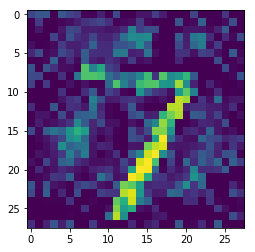

In [153]:
plt.imshow(adv[0, :, :, 0])

---

# V6

margin: 1e2, reg: 1e-2 only last layer

In [ ]:
from hinge_net import HingeNet

# v6: margin = 1e2
hingenet = HingeNet("hingenet_v6", [28, 28, 1], [10], learning_rate=1e-3, 
                    load_model=True, save_path="model/hingenet_v6.h5")
# hingenet.train_model(sess, data, n_epoch=10, batch_size=128)

In [ ]:
w = hingenet.model.get_weights()
for i, w in enumerate(w):
    if i % 2 == 0:
        print(np.sum(np.square(w)))

In [ ]:
# Least likeley class
n_attack = 1000
X_atk = X_test[:, :, :, np.newaxis][:n_attack]
y_atk = np.argmax(y_test[:n_attack], axis=1)

y_pred = hingenet.predict_model(sess, X_atk)
y_target = to_categorical(np.argmin(y_pred, axis=1))

print(hingenet.eval_model(sess, (X_atk, y_atk)))

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 200
cw_params = {'binary_search_steps': 3,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': 100,
             'initial_const': 10,
             'y_target': y_target}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

In [ ]:
print(hingenet.eval_model(sess, (adv, np.argmax(y_target, axis=1))))
print(np.sqrt(np.mean(np.sum((adv - X_atk)**2, (1, 2, 3)))))

## V6-1

In [ ]:
from hinge_net import HingeNet

# v6: margin = 1e2
hingenet = HingeNet("hingenet_v6-1", [28, 28, 1], [10], learning_rate=1e-3, 
                    load_model=True, save_path="model/hingenet_v6-1.h5")
# hingenet.train_model(sess, data, n_epoch=10, batch_size=128)

In [ ]:
w = hingenet.model.get_weights()
for i, w in enumerate(w):
    if i % 2 == 0:
        print(np.sum(np.square(w)))

In [ ]:
# Least likeley class
n_attack = 1000
X_atk = X_test[:, :, :, np.newaxis][:n_attack]
y_atk = np.argmax(y_test[:n_attack], axis=1)

y_pred = hingenet.predict_model(sess, X_atk)
y_target = to_categorical(np.argmin(y_pred, axis=1))

print(hingenet.eval_model(sess, (X_atk, y_atk)))

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 200
cw_params = {'binary_search_steps': 3,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': 100,
             'initial_const': 10,
             'y_target': y_target}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

print(hingenet.eval_model(sess, (adv, np.argmax(y_target, axis=1))))
print(np.sqrt(np.mean(np.sum((adv - X_atk)**2, (1, 2, 3)))))

---

# V7

margin: 1, last layer is sigmoid

In [ ]:
from hinge_net import HingeNet

hingenet = HingeNet("hingenet_v7", [28, 28, 1], [10], learning_rate=1e-3, 
                    load_model=True, save_path="model/hingenet_v7.h5")
hingenet.train_model(sess, data, n_epoch=10, batch_size=128)

In [ ]:
w = hingenet.model.get_weights()
for i, w in enumerate(w):
    if i % 2 == 0:
        print(np.sum(np.square(w)))

In [ ]:
# Least likeley class
n_attack = 1000
X_atk = X_test[:, :, :, np.newaxis][:n_attack]
y_atk = np.argmax(y_test[:n_attack], axis=1)

y_pred = hingenet.predict_model(sess, X_atk)
y_target = to_categorical(np.argmin(y_pred, axis=1))

print(hingenet.eval_model(sess, (X_atk, y_atk)))

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 200
cw_params = {'binary_search_steps': 3,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': 100,
             'initial_const': 10,
             'y_target': y_target}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

print(hingenet.eval_model(sess, (adv, np.argmax(y_target, axis=1))))
print(np.sqrt(np.mean(np.sum((adv - X_atk)**2, (1, 2, 3)))))

### attack at layer before sigmoid

In [ ]:
from hinge_net import HingeNet

hingenet = HingeNet("hingenet_v7", [28, 28, 1], [10], learning_rate=1e-3, 
                    load_model=True, save_path="model/hingenet_v7.h5")
# hingenet.train_model(sess, data, n_epoch=10, batch_size=128)

In [ ]:
w = hingenet.model.get_weights()
for i, w in enumerate(w):
    if i % 2 == 0:
        print(np.sum(np.square(w)))

In [ ]:
# Least likeley class
n_attack = 1000
X_atk = X_test[:, :, :, np.newaxis][:n_attack]
y_atk = np.argmax(y_test[:n_attack], axis=1)

y_pred = hingenet.predict_model(sess, X_atk)
y_target = to_categorical(np.argmin(y_pred, axis=1))

print(hingenet.eval_model(sess, (X_atk, y_atk)))

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 200
cw_params = {'binary_search_steps': 3,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': 100,
             'initial_const': 10,
             'y_target': y_target}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

print(hingenet.eval_model(sess, (adv, np.argmax(y_target, axis=1))))
print(np.sqrt(np.mean(np.sum((adv - X_atk)**2, (1, 2, 3)))))

In [ ]:
y_pred = hingenet.predict_model(sess, adv)

for x, y in zip(adv[:10], y_pred[:10]):
    print(np.argmax(y))
    print(y)
    plt.imshow(x[:, :, 0])
    plt.show()

In [ ]:
y_pred = hingenet.predict_model(sess, X_test[:10, :, :, np.newaxis])

for x, y in zip(X_test[:10], y_pred):
    print(np.argmax(y))
    print(y)
    plt.imshow(x)
    plt.show()

In [ ]:
y_pred = hingenet.predict_model(sess, X_test[:, :, :, np.newaxis])
y_sort = np.argsort(y_pred, axis=1)[:, ::-1]
y_final = np.zeros(len(y_pred)) - 1
for i in range(len(y_pred)):
    d = y_pred[i, y_sort[i, 0]] - y_pred[i, y_sort[i, 1]]
    if d >= 0.75:
        y_final[i] = y_sort[i, 0]
np.mean(y_final == np.argmax(y_test, axis=1))

In [ ]:
# Least likeley class
n_attack = 1000
X_atk = X_test[:, :, :, np.newaxis][:n_attack]
y_atk = np.argmax(y_test[:n_attack], axis=1)

y_pred = hingenet.predict_model(sess, X_atk)
y_target = to_categorical(np.argmin(y_pred, axis=1))

print(hingenet.eval_model(sess, (X_atk, y_atk)))

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 200
cw_params = {'binary_search_steps': 3,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': 100,
             'initial_const': 10,
             'y_target': y_target,
             'confidence': 0.75}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

# print(hingenet.eval_model(sess, (adv, np.argmax(y_target, axis=1))))
print(np.sqrt(np.mean(np.sum((adv - X_atk)**2, (1, 2, 3)))))

In [ ]:
y_pred = hingenet.predict_model(sess, adv)
y_sort = np.argsort(y_pred, axis=1)[:, ::-1]
y_final = np.zeros(len(y_pred)) - 1
for i in range(len(y_pred)):
    d = y_pred[i, y_sort[i, 0]] - y_pred[i, y_sort[i, 1]]
    if d >= 0.75:
        y_final[i] = y_sort[i, 0]
np.mean(y_final == np.argmax(y_target, axis=1))

In [ ]:
y_pred = hingenet.predict_model(sess, adv)

for x, y in zip(adv[:10], y_pred[:10]):
    print(np.argmax(y))
    print(y)
    plt.imshow(x[:, :, 0])
    plt.show()

---

# V8

Large network, margin: 1

In [ ]:
from hinge_net import HingeNet

hingenet = HingeNet("hingenet_v8", [28, 28, 1], [10], learning_rate=1e-3, 
                    load_model=True, save_path="model/hingenet_v8.h5")
hingenet.train_model(sess, data, n_epoch=10, batch_size=128)

In [ ]:
w = hingenet.model.get_weights()
for i, w in enumerate(w):
    if i % 2 == 0:
        print(np.sum(np.square(w)))

In [ ]:
# Least likeley class
n_attack = 1000
X_atk = X_test[:, :, :, np.newaxis][:n_attack]
y_atk = np.argmax(y_test[:n_attack], axis=1)

y_pred = hingenet.predict_model(sess, X_atk)
y_target = to_categorical(np.argmin(y_pred, axis=1))

print(hingenet.eval_model(sess, (X_atk, y_atk)))

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 200
cw_params = {'binary_search_steps': 3,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': 100,
             'initial_const': 10,
             'y_target': y_target}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

print(hingenet.eval_model(sess, (adv, np.argmax(y_target, axis=1))))
print(np.sqrt(np.mean(np.sum((adv - X_atk)**2, (1, 2, 3)))))

In [ ]:
from hinge_net import HingeNet

hingenet = HingeNet("hingenet_v8-1", [28, 28, 1], [10], learning_rate=1e-3, 
                    load_model=True, save_path="model/hingenet_v8-1.h5")
hingenet.train_model(sess, data, n_epoch=10, batch_size=128)

In [ ]:
w = hingenet.model.get_weights()
for i, w in enumerate(w):
    if i % 2 == 0:
        print(np.sum(np.square(w)))

In [ ]:
# Least likeley class
n_attack = 1000
X_atk = X_test[:, :, :, np.newaxis][:n_attack]
y_atk = np.argmax(y_test[:n_attack], axis=1)

y_pred = hingenet.predict_model(sess, X_atk)
y_target = to_categorical(np.argmin(y_pred, axis=1))

print(hingenet.eval_model(sess, (X_atk, y_atk)))

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 200
cw_params = {'binary_search_steps': 3,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': 100,
             'initial_const': 10,
             'y_target': y_target}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

print(hingenet.eval_model(sess, (adv, np.argmax(y_target, axis=1))))
print(np.sqrt(np.mean(np.sum((adv - X_atk)**2, (1, 2, 3)))))

In [ ]:
from hinge_net import HingeNet

hingenet = HingeNet("hingenet_v8-2", [28, 28, 1], [10], learning_rate=1e-3, 
                    load_model=True, save_path="model/hingenet_v8-2.h5")
hingenet.train_model(sess, data, n_epoch=10, batch_size=128)

In [ ]:
w = hingenet.model.get_weights()
for i, w in enumerate(w):
    if i % 2 == 0:
        print(np.sum(np.square(w)))

In [ ]:
# Least likeley class
n_attack = 1000
X_atk = X_test[:, :, :, np.newaxis][:n_attack]
y_atk = np.argmax(y_test[:n_attack], axis=1)

y_pred = hingenet.predict_model(sess, X_atk)
y_target = to_categorical(np.argmin(y_pred, axis=1))

print(hingenet.eval_model(sess, (X_atk, y_atk)))

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 200
cw_params = {'binary_search_steps': 3,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': 100,
             'initial_const': 10,
             'y_target': y_target}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

print(hingenet.eval_model(sess, (adv, np.argmax(y_target, axis=1))))
print(np.sqrt(np.mean(np.sum((adv - X_atk)**2, (1, 2, 3)))))

---

# V9

margin: 1e2, last layer is softmax

In [ ]:
from hinge_net import HingeNet

hingenet = HingeNet("hingenet_v9", [28, 28, 1], [10], learning_rate=1e-3, 
                    load_model=True, save_path="model/hingenet_v9.h5")
hingenet.train_model(sess, data, n_epoch=10, batch_size=128)

In [ ]:
w = hingenet.model.get_weights()
for i, w in enumerate(w):
    if i % 2 == 0:
        print(np.sum(np.square(w)))

In [ ]:
# Least likeley class
n_attack = 1000
X_atk = X_test[:, :, :, np.newaxis][:n_attack]
y_atk = np.argmax(y_test[:n_attack], axis=1)

y_pred = hingenet.predict_model(sess, X_atk)
y_target = to_categorical(np.argmin(y_pred, axis=1))

print(hingenet.eval_model(sess, (X_atk, y_atk)))

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 200
cw_params = {'binary_search_steps': 3,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': 100,
             'initial_const': 10,
             'y_target': y_target}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

print(hingenet.eval_model(sess, (adv, np.argmax(y_target, axis=1))))
print(np.sqrt(np.mean(np.sum((adv - X_atk)**2, (1, 2, 3)))))

## V9-2

margin 1, softmax

In [ ]:
from hinge_net import HingeNet

hingenet = HingeNet("hingenet_v9-2", [28, 28, 1], [10], learning_rate=1e-3, 
                    load_model=True, save_path="model/hingenet_v9-2.h5")
hingenet.train_model(sess, data, n_epoch=10, batch_size=128)

In [ ]:
w = hingenet.model.get_weights()
for i, w in enumerate(w):
    if i % 2 == 0:
        print(np.sum(np.square(w)))

In [ ]:
# Least likeley class
n_attack = 1000
X_atk = X_test[:, :, :, np.newaxis][:n_attack]
y_atk = np.argmax(y_test[:n_attack], axis=1)

y_pred = hingenet.predict_model(sess, X_atk)
y_target = to_categorical(np.argmin(y_pred, axis=1), 10)

print(hingenet.eval_model(sess, (X_atk, y_atk)))

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 200
cw_params = {'binary_search_steps': 3,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': 100,
             'initial_const': 10,
             'y_target': y_target}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

print(hingenet.eval_model(sess, (adv, np.argmax(y_target, axis=1))))
print(np.sqrt(np.mean(np.sum((adv - X_atk)**2, (1, 2, 3)))))

## V9-1

margin 1, log

In [ ]:
from hinge_net import HingeNet

hingenet = HingeNet("hingenet_v9-1", [28, 28, 1], [10], learning_rate=1e-3, 
                    load_model=False, save_path="model/hingenet_v9-1.h5")
hingenet.train_model(sess, data, n_epoch=10, batch_size=128)

In [ ]:
w = hingenet.model.get_weights()
for i, w in enumerate(w):
    if i % 2 == 0:
        print(np.sum(np.square(w)))

In [ ]:
# Least likeley class
n_attack = 1000
X_atk = X_test[:, :, :, np.newaxis][:n_attack]
y_atk = np.argmax(y_test[:n_attack], axis=1)

y_pred = hingenet.predict_model(sess, X_atk)
y_target = to_categorical(np.argmin(y_pred, axis=1), 10)

print(hingenet.eval_model(sess, (X_atk, y_atk)))

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 200
cw_params = {'binary_search_steps': 3,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': 100,
             'initial_const': 10,
             'y_target': y_target}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

print(hingenet.eval_model(sess, (adv, np.argmax(y_target, axis=1))))
print(np.sqrt(np.mean(np.sum((adv - X_atk)**2, (1, 2, 3)))))

In [ ]:
ph = tf.placeholder(tf.float32, [10, 28, 28, 1])
y_pred = sess.run(hingenet.get_output(ph), feed_dict={ph: adv[:10]})

for x, y in zip(adv[:10], y_pred[:10]):
    print(np.argmax(y))
    print(y)
    plt.imshow(x[:, :, 0])
    plt.show()

---
# V10

In [305]:
from hinge_net import HingeNet

hingenet = HingeNet("v10.3", [28, 28, 1], [10], learning_rate=1e-3, 
                    loss="hinge", margin=2, reg=0, activation="custom",
                    load_model=True, save_path="model/v10.3.h5")
hingenet.train_model(sess, data, n_epoch=10, batch_size=128)

Saved weights not found...
Model was built, but no weight was loaded
============= EPOCH: 0 =============
STEP: 0 	Loss: 2.2861
STEP: 50 	Loss: 0.5436
STEP: 100 	Loss: 0.4075
STEP: 150 	Loss: 0.2423
STEP: 200 	Loss: 0.1894
STEP: 250 	Loss: 0.2103
STEP: 300 	Loss: 0.1851
STEP: 350 	Loss: 0.2330
STEP: 400 	Loss: 0.1302
STEP: 450 	Loss: 0.1250
Train Acc|Loss:	0.9760|0.1186
Val Acc|Loss:	0.9743|0.1261
============= EPOCH: 1 =============
STEP: 0 	Loss: 0.1953
STEP: 50 	Loss: 0.1399
STEP: 100 	Loss: 0.1659
STEP: 150 	Loss: 0.0294
STEP: 200 	Loss: 0.1054
STEP: 250 	Loss: 0.1019
STEP: 300 	Loss: 0.1171
STEP: 350 	Loss: 0.0870
STEP: 400 	Loss: 0.1796
STEP: 450 	Loss: 0.1205
Train Acc|Loss:	0.9846|0.0781
Val Acc|Loss:	0.9785|0.1036
============= EPOCH: 2 =============
STEP: 0 	Loss: 0.0794
STEP: 50 	Loss: 0.0554
STEP: 100 	Loss: 0.1219
STEP: 150 	Loss: 0.0908
STEP: 200 	Loss: 0.0601
STEP: 250 	Loss: 0.0647
STEP: 300 	Loss: 0.0902
STEP: 350 	Loss: 0.0364
STEP: 400 	Loss: 0.0786
STEP: 450 	Loss: 

In [306]:
hingenet.eval_model(sess, (X_test[:, :, :, np.newaxis], np.argmax(y_test, axis=1)))

(0.9851, 0.07231615725755691)

In [307]:
# Least likeley class
n_attack = 1000
X_atk = X_test[:, :, :, np.newaxis][:n_attack]
y_atk = np.argmax(y_test[:n_attack], axis=1)

y_pred = hingenet.predict_model(sess, X_atk)
y_target = to_categorical(np.argmin(y_pred, axis=1), 10)
# y_target = to_categorical((np.argmax(y_pred, axis=1) + 1) % 10)

In [308]:
y_target

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [309]:
hingenet.eval_model(sess, (X_atk, y_atk))

(0.98, 0.08815036082267762)

In [310]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 500
cw_params = {'binary_search_steps': 10,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': n_attack,
             'initial_const': 1,
             'y_target': y_target}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

[INFO 2018-10-25 20:03:06,911 cleverhans] Constructing new graph for attack CarliniWagnerL2
[DEBUG 2018-10-25 20:03:09,059 cleverhans] Running CWL2 attack on instance 0 of 1000
[DEBUG 2018-10-25 20:03:09,602 cleverhans]   Binary search step 0 of 10
[DEBUG 2018-10-25 20:03:14,912 cleverhans]     Iteration 0 of 500: loss=108 l2=0
[DEBUG 2018-10-25 20:03:16,945 cleverhans]     Iteration 50 of 500: loss=27.7 l2=8.63
[DEBUG 2018-10-25 20:03:18,919 cleverhans]     Iteration 100 of 500: loss=21 l2=6.34
[DEBUG 2018-10-25 20:03:20,755 cleverhans]     Iteration 150 of 500: loss=18.9 l2=5.63
[DEBUG 2018-10-25 20:03:22,494 cleverhans]     Iteration 200 of 500: loss=17.8 l2=5.15
[DEBUG 2018-10-25 20:03:24,177 cleverhans]     Iteration 250 of 500: loss=16.5 l2=4.81
[DEBUG 2018-10-25 20:03:25,821 cleverhans]     Iteration 300 of 500: loss=15.3 l2=4.54
[DEBUG 2018-10-25 20:03:27,451 cleverhans]     Iteration 350 of 500: loss=14.2 l2=4.31
[DEBUG 2018-10-25 20:03:29,018 cleverhans]     Iteration 400 of 

[DEBUG 2018-10-25 20:05:04,745 cleverhans]    Mean successful distortion: 1.798
[DEBUG 2018-10-25 20:05:04,746 cleverhans]   Binary search step 9 of 10
[DEBUG 2018-10-25 20:05:04,769 cleverhans]     Iteration 0 of 500: loss=6.1e+09 l2=0
[DEBUG 2018-10-25 20:05:04,770 cleverhans]     Failed to make progress; stop early
[DEBUG 2018-10-25 20:05:04,784 cleverhans]   Successfully generated adversarial examples on 945 of 1000 instances.
[DEBUG 2018-10-25 20:05:04,785 cleverhans]    Mean successful distortion: 1.798


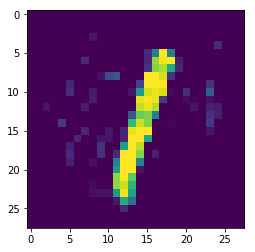

In [314]:
plt.imshow(adv[5, :, :, 0])

In [284]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

from lib.my_pgd import ProjectedGradientDescent

pgd_params = {'eps': 0.3,
              'eps_iter': 0.05,
              'clip_min': 0.,
              'clip_max': 1.,
              'ord': np.inf, 
              'nb_iter': 10,
              'rand_init': True,
              'batch_size': 100}
pgd = ProjectedGradientDescent(hingenet, sess=sess)

y_tar = np.argmax(y_target, axis=1)
best_adv = np.zeros_like(X_atk)
best_dist = np.zeros([n_attack]) + 1e5
for i in range(10):
    adv = pgd.generate_np(X_atk, **pgd_params)
    print(hingenet.eval_model(sess, (adv, y_tar)))
    dist = np.sqrt(np.sum((adv - X_atk)**2, (1, 2, 3)))
    print(np.mean(dist))
    pred = hingenet.predict_model(sess, adv)
    y_pred = np.argmax(pred, axis=1)
    for j in range(n_attack):
        if y_pred[j] == y_tar[j] and dist[j] < best_dist[j]:
            best_adv[j] = adv[j]
            best_dist[j] = dist[j]
print(np.mean(best_dist < 1e5))
print(np.mean(best_dist[best_dist < 1e5]))

/home/research/nn_proof/lib/my_pgd.py:698: UserWarning: Supplied extra keyword arguments that are not used in the graph computation. They have been ignored.
  warnings.warn("Supplied extra keyword arguments that are not "
[INFO 2018-10-25 19:23:26,621 cleverhans] Constructing new graph for attack ProjectedGradientDescent


(0.049, 2.8439740867614747)
4.038855
(0.053, 2.8361883239746093)
4.038858
(0.043, 2.850980401992798)
4.0296144
(0.058, 2.8289904518127442)
4.0250134
(0.047, 2.850432149887085)
4.0323324
(0.045, 2.846483455657959)
4.0422564
(0.05, 2.846467294692993)
4.0337825
(0.039, 2.8638558540344237)
4.0279226
(0.048, 2.8542617073059082)
4.037876
(0.051, 2.835804832458496)
4.0379004
0.152
3.9598035859434226


In [304]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 500
cw_params = {'binary_search_steps': 10,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': n_attack,
             'initial_const': 10}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

[INFO 2018-10-25 19:59:12,229 cleverhans] Constructing new graph for attack CarliniWagnerL2
[DEBUG 2018-10-25 19:59:14,384 cleverhans] Running CWL2 attack on instance 0 of 1000
[DEBUG 2018-10-25 19:59:14,959 cleverhans]   Binary search step 0 of 10
[DEBUG 2018-10-25 19:59:20,216 cleverhans]     Iteration 0 of 500: loss=72.8 l2=0
[DEBUG 2018-10-25 19:59:21,991 cleverhans]     Iteration 50 of 500: loss=19.3 l2=4.49
[DEBUG 2018-10-25 19:59:23,867 cleverhans]     Iteration 100 of 500: loss=16.6 l2=2.71
[DEBUG 2018-10-25 19:59:25,564 cleverhans]     Iteration 150 of 500: loss=15.7 l2=2.4
[DEBUG 2018-10-25 19:59:27,158 cleverhans]     Iteration 200 of 500: loss=15.3 l2=2.31
[DEBUG 2018-10-25 19:59:28,713 cleverhans]     Iteration 250 of 500: loss=14.9 l2=2.23
[DEBUG 2018-10-25 19:59:30,237 cleverhans]     Iteration 300 of 500: loss=14.3 l2=2.15
[DEBUG 2018-10-25 19:59:31,773 cleverhans]     Iteration 350 of 500: loss=13.3 l2=2.12
[DEBUG 2018-10-25 19:59:33,300 cleverhans]     Iteration 400 o

---
# Softmax

In [73]:
from hinge_net import HingeNet

hingenet = HingeNet("softmax_xent", [28, 28, 1], [10], learning_rate=1e-3, 
                    loss="xent", load_model=True, save_path="model/softmax_xent.h5")
# hingenet.train_model(sess, data, n_epoch=10, batch_size=128)

In [74]:
hingenet.eval_model(sess, (X_test[:, :, :, np.newaxis], np.argmax(y_test, axis=1)))

(0.993, 0.02630199917015052)

In [75]:
# Least likeley class
n_attack = 1000
X_atk = X_test[:, :, :, np.newaxis][:n_attack]
y_atk = np.argmax(y_test[:n_attack], axis=1)

y_pred = hingenet.predict_model(sess, X_atk)
y_target = to_categorical(np.argmin(y_pred, axis=1))
# y_target = to_categorical((np.argmax(y_pred, axis=1) + 1) % 10)

In [76]:
hingenet.eval_model(sess, (X_atk, y_atk))

(0.993, 0.01569840869307518)

In [ ]:
# softmax_xent

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

from lib.my_pgd import ProjectedGradientDescent

pgd_params = {'eps': 0.3,
              'eps_iter': 0.05,
              'clip_min': 0.,
              'clip_max': 1.,
              'ord': np.inf, 
              'nb_iter': 10,
              'rand_init': True,
              'batch_size': 100,
              'y_target': y_target}
pgd = ProjectedGradientDescent(hingenet, sess=sess)

y_tar = np.argmax(y_target, axis=1)
best_adv = np.zeros_like(X_atk)
best_dist = np.zeros([n_attack]) + 1e5
for i in range(10):
    adv = pgd.generate_np(X_atk, **pgd_params)
    print(hingenet.eval_model(sess, (adv, y_tar)))
    dist = np.sqrt(np.sum((adv - X_atk)**2, (1, 2, 3)))
    print(np.mean(dist))
    pred = hingenet.predict_model(sess, adv)
    y_pred = np.argmax(pred, axis=1)
    for j in range(n_attack):
        if y_pred[j] == y_tar[j] and dist[j] < best_dist[j]:
            best_adv[j] = adv[j]
            best_dist[j] = dist[j]
print(np.mean(best_dist < 1e5))
print(np.mean(best_dist[best_dist < 1e5]))

In [ ]:
# softmax_xent (untargeted)

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

from lib.my_pgd import ProjectedGradientDescent

pgd_params = {'eps': 0.3,
              'eps_iter': 0.05,
              'clip_min': 0.,
              'clip_max': 1.,
              'ord': np.inf, 
              'nb_iter': 10,
              'rand_init': True,
              'batch_size': 100}
pgd = ProjectedGradientDescent(hingenet, sess=sess)

y_tar = np.argmax(y_target, axis=1)
best_adv = np.zeros_like(X_atk)
best_dist = np.zeros([n_attack]) + 1e5
for i in range(10):
    adv = pgd.generate_np(X_atk, **pgd_params)
    print(hingenet.eval_model(sess, (adv, y_tar)))
    dist = np.sqrt(np.sum((adv - X_atk)**2, (1, 2, 3)))
    print(np.mean(dist))
    pred = hingenet.predict_model(sess, adv)
    y_pred = np.argmax(pred, axis=1)
    for j in range(n_attack):
        if y_pred[j] == y_tar[j] and dist[j] < best_dist[j]:
            best_adv[j] = adv[j]
            best_dist[j] = dist[j]
print(np.mean(best_dist < 1e5))
print(np.mean(best_dist[best_dist < 1e5]))

In [20]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 500
cw_params = {'binary_search_steps': 10,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': n_attack,
             'initial_const': 1,
             'y_target': y_target}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

[INFO 2018-10-25 00:06:30,614 cleverhans] Constructing new graph for attack CarliniWagnerL2
[DEBUG 2018-10-25 00:06:30,879 cleverhans] Running CWL2 attack on instance 0 of 1000
[DEBUG 2018-10-25 00:06:30,979 cleverhans]   Binary search step 0 of 10
[DEBUG 2018-10-25 00:06:31,139 cleverhans]     Iteration 0 of 500: loss=38.1 l2=0
[DEBUG 2018-10-25 00:06:32,926 cleverhans]     Iteration 50 of 500: loss=11.4 l2=8.99
[DEBUG 2018-10-25 00:06:34,610 cleverhans]     Iteration 100 of 500: loss=10.4 l2=8.35
[DEBUG 2018-10-25 00:06:36,213 cleverhans]     Iteration 150 of 500: loss=9.76 l2=8.31
[DEBUG 2018-10-25 00:06:37,821 cleverhans]     Iteration 200 of 500: loss=8.87 l2=7.95
[DEBUG 2018-10-25 00:06:39,422 cleverhans]     Iteration 250 of 500: loss=8.07 l2=7.46
[DEBUG 2018-10-25 00:06:40,976 cleverhans]     Iteration 300 of 500: loss=7.48 l2=7
[DEBUG 2018-10-25 00:06:42,500 cleverhans]     Iteration 350 of 500: loss=7.03 l2=6.66
[DEBUG 2018-10-25 00:06:43,985 cleverhans]     Iteration 400 of 

[DEBUG 2018-10-25 00:08:28,376 cleverhans]     Iteration 50 of 500: loss=10.1 l2=6.6
[DEBUG 2018-10-25 00:08:30,036 cleverhans]     Iteration 100 of 500: loss=9.55 l2=6.42
[DEBUG 2018-10-25 00:08:31,673 cleverhans]     Iteration 150 of 500: loss=9.26 l2=6.44
[DEBUG 2018-10-25 00:08:33,304 cleverhans]     Iteration 200 of 500: loss=8.72 l2=6.38
[DEBUG 2018-10-25 00:08:34,930 cleverhans]     Iteration 250 of 500: loss=8.09 l2=6.24
[DEBUG 2018-10-25 00:08:36,561 cleverhans]     Iteration 300 of 500: loss=7.57 l2=6.1
[DEBUG 2018-10-25 00:08:38,212 cleverhans]     Iteration 350 of 500: loss=7.14 l2=6
[DEBUG 2018-10-25 00:08:39,877 cleverhans]     Iteration 400 of 500: loss=6.77 l2=5.95
[DEBUG 2018-10-25 00:08:41,571 cleverhans]     Iteration 450 of 500: loss=6.47 l2=5.89
[DEBUG 2018-10-25 00:08:43,241 cleverhans]   Successfully generated adversarial examples on 1000 of 1000 instances.
[DEBUG 2018-10-25 00:08:43,242 cleverhans]    Mean successful distortion: 2.409
[DEBUG 2018-10-25 00:08:43,

In [ ]:
dist = np.sqrt(np.sum((X_atk - adv)**2, (1, 2, 3)))
plt.hist(dist)
print(np.min(dist))

In [22]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 1000
cw_params = {'binary_search_steps': 10,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': n_attack,
             'initial_const': 1,
             'y_target': y_target}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

[INFO 2018-10-25 00:17:49,337 cleverhans] Constructing new graph for attack CarliniWagnerL2
[DEBUG 2018-10-25 00:17:49,713 cleverhans] Running CWL2 attack on instance 0 of 1000
[DEBUG 2018-10-25 00:17:49,821 cleverhans]   Binary search step 0 of 10
[DEBUG 2018-10-25 00:17:50,002 cleverhans]     Iteration 0 of 1000: loss=38.1 l2=0
[DEBUG 2018-10-25 00:17:53,482 cleverhans]     Iteration 100 of 1000: loss=10.4 l2=8.35
[DEBUG 2018-10-25 00:17:56,757 cleverhans]     Iteration 200 of 1000: loss=8.87 l2=7.95
[DEBUG 2018-10-25 00:17:59,911 cleverhans]     Iteration 300 of 1000: loss=7.47 l2=7
[DEBUG 2018-10-25 00:18:02,890 cleverhans]     Iteration 400 of 1000: loss=6.7 l2=6.4
[DEBUG 2018-10-25 00:18:05,710 cleverhans]     Iteration 500 of 1000: loss=6.26 l2=6
[DEBUG 2018-10-25 00:18:08,418 cleverhans]     Iteration 600 of 1000: loss=5.96 l2=5.75
[DEBUG 2018-10-25 00:18:11,049 cleverhans]     Iteration 700 of 1000: loss=5.77 l2=5.6
[DEBUG 2018-10-25 00:18:13,672 cleverhans]     Iteration 800 

[DEBUG 2018-10-25 00:21:39,101 cleverhans]     Iteration 0 of 1000: loss=18.4 l2=0
[DEBUG 2018-10-25 00:21:42,548 cleverhans]     Iteration 100 of 1000: loss=8.7 l2=5.25
[DEBUG 2018-10-25 00:21:45,885 cleverhans]     Iteration 200 of 1000: loss=8.24 l2=5.26
[DEBUG 2018-10-25 00:21:49,216 cleverhans]     Iteration 300 of 1000: loss=7.34 l2=5.11
[DEBUG 2018-10-25 00:21:52,581 cleverhans]     Iteration 400 of 1000: loss=6.68 l2=5.03
[DEBUG 2018-10-25 00:21:55,967 cleverhans]     Iteration 500 of 1000: loss=6.24 l2=4.99
[DEBUG 2018-10-25 00:21:59,287 cleverhans]     Iteration 600 of 1000: loss=5.92 l2=4.98
[DEBUG 2018-10-25 00:22:02,642 cleverhans]     Iteration 700 of 1000: loss=5.69 l2=4.97
[DEBUG 2018-10-25 00:22:06,007 cleverhans]     Iteration 800 of 1000: loss=5.52 l2=4.97
[DEBUG 2018-10-25 00:22:09,394 cleverhans]     Iteration 900 of 1000: loss=5.39 l2=4.96
[DEBUG 2018-10-25 00:22:12,759 cleverhans]   Successfully generated adversarial examples on 1000 of 1000 instances.
[DEBUG 201

In [78]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.my_cw import CarliniWagnerL2

attack_iterations = 500
cw_params = {'binary_search_steps': 10,
             'max_iterations': attack_iterations,
             'learning_rate': 0.1,
             'batch_size': n_attack,
             'initial_const': 1}
cw = CarliniWagnerL2(hingenet, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

[INFO 2018-10-25 04:11:13,405 cleverhans] Constructing new graph for attack CarliniWagnerL2
[DEBUG 2018-10-25 04:11:13,931 cleverhans] Running CWL2 attack on instance 0 of 1000
[DEBUG 2018-10-25 04:11:14,074 cleverhans]   Binary search step 0 of 10
[DEBUG 2018-10-25 04:11:14,350 cleverhans]     Iteration 0 of 500: loss=16.5 l2=0
[DEBUG 2018-10-25 04:11:15,990 cleverhans]     Iteration 50 of 500: loss=4.31 l2=3.79
[DEBUG 2018-10-25 04:11:17,384 cleverhans]     Iteration 100 of 500: loss=4 l2=3.52
[DEBUG 2018-10-25 04:11:18,700 cleverhans]     Iteration 150 of 500: loss=3.83 l2=3.46
[DEBUG 2018-10-25 04:11:19,989 cleverhans]     Iteration 200 of 500: loss=3.54 l2=3.33
[DEBUG 2018-10-25 04:11:21,266 cleverhans]     Iteration 250 of 500: loss=3.25 l2=3.11
[DEBUG 2018-10-25 04:11:22,525 cleverhans]     Iteration 300 of 500: loss=3 l2=2.89
[DEBUG 2018-10-25 04:11:23,749 cleverhans]     Iteration 350 of 500: loss=2.84 l2=2.73
[DEBUG 2018-10-25 04:11:24,982 cleverhans]     Iteration 400 of 500

[DEBUG 2018-10-25 04:13:09,058 cleverhans]     Iteration 50 of 500: loss=3.44 l2=1.76
[DEBUG 2018-10-25 04:13:10,787 cleverhans]     Iteration 100 of 500: loss=3.41 l2=1.76
[DEBUG 2018-10-25 04:13:12,587 cleverhans]     Iteration 150 of 500: loss=3.4 l2=1.76
[DEBUG 2018-10-25 04:13:14,397 cleverhans]     Iteration 200 of 500: loss=3.37 l2=1.78
[DEBUG 2018-10-25 04:13:16,151 cleverhans]     Iteration 250 of 500: loss=3.29 l2=1.81
[DEBUG 2018-10-25 04:13:17,863 cleverhans]     Iteration 300 of 500: loss=3.15 l2=1.88
[DEBUG 2018-10-25 04:13:19,613 cleverhans]     Iteration 350 of 500: loss=3 l2=1.96
[DEBUG 2018-10-25 04:13:21,312 cleverhans]     Iteration 400 of 500: loss=2.85 l2=2.06
[DEBUG 2018-10-25 04:13:23,013 cleverhans]     Iteration 450 of 500: loss=2.71 l2=2.15
[DEBUG 2018-10-25 04:13:24,705 cleverhans]   Successfully generated adversarial examples on 1000 of 1000 instances.
[DEBUG 2018-10-25 04:13:24,706 cleverhans]    Mean successful distortion: 1.442
[DEBUG 2018-10-25 04:13:24

In [ ]:
y_pred = hingenet.predict_model(sess, adv)

for x, y in zip(adv[:10], y_pred[:10]):
    print(np.argmax(y))
    print(y)
    plt.imshow(x[:, :, 0])
    plt.show()

In [ ]:
K.clear_session()
del hingenet.model
del hingenet

In [ ]:
tf.global_variables()

In [ ]:
import gc
gc.collect()

In [ ]:
from keras.layers import (Activation, Dense, Flatten, Lambda, Conv2D, Input,
                          MaxPooling2D, Reshape, Concatenate, Cropping2D, Add,
                          Dropout)

inpt = Input(shape=(28, 28, 1))
conv1 = Conv2D(32, (5, 5), activation='relu')(inpt)
conv2 = Conv2D(64, (3, 3), activation='relu')(conv1)
conv3 = Conv2D(128, (3, 3), activation='relu')(conv2)
flat = Flatten()(conv3)
dense1 = Dense(512, activation='relu')(flat)
drop1 = Dropout(0.25)(dense1)
dense2 = Dense(128, activation='relu')(drop1)
drop2 = Dropout(0.5)(dense2)
output = Dense(10, activation=None)(drop2)
model = keras.models.Model(inputs=inpt, outputs=output)

In [ ]:
model.load_weights("model/softmax_xent.h5")

In [ ]:
import foolbox

# instantiate model
keras.backend.set_learning_phase(0)
kmodel = model
preprocessing = (np.array([0, 0, 0]), 1)
fmodel = foolbox.models.KerasModel(kmodel, bounds=(0, 1), 
                                   preprocessing=preprocessing,
                                   predicts='logits')

# apply attack on source image
# attack = foolbox.attacks.FGSM(fmodel)
# adv = attack(X_atk[0], label=y_atk[0], unpack=True, epsilons=1000, max_epsilon=1)

# from foolbox.attacks import LBFGSAttack
# from foolbox.criteria import TargetClassProbability

# criterion = TargetClassProbability(6, p=0.99)
# attack = LBFGSAttack(fmodel, criterion)
# adv = attack(X_atk[0], label=y_atk[0])

from foolbox.attacks import BoundaryAttack
from foolbox.criteria import TargetClassProbability

criterion = TargetClassProbability(6, p=0.99)
attack = BoundaryAttack(fmodel, criterion)
adv = attack(X_atk[0], label=y_atk[0],
             iterations=5000, max_directions=25, starting_point=X_atk[11], 
             initialization_attack=None, log_every_n_steps=1, 
             spherical_step=0.01, source_step=0.01, step_adaptation=1.5, 
             batch_size=1, tune_batch_size=True, threaded_rnd=True, 
             threaded_gen=True, alternative_generator=False, verbose=False)

In [ ]:
model.predict(X_atk[0][np.newaxis])

In [ ]:
model.predict(adv[np.newaxis])

In [ ]:
np.sum(np.square(adv - X_atk[0]))

In [ ]:
plt.imshow(adv[:, :, 0])

In [ ]:
plt.imshow(X_atk[0, :, :, 0])

In [ ]:
plt.imshow(X_atk[11, :, :, 0])